# Neural Networks in PyTorch
## Chapter 8: Convolutional Layers and Convolutional Neural Networks

Yen Lee Loh, 2021-9-8, 2022-11-23

In this chapter, we perform binary classification on a digit pair using a CNN.  We also examine the weights and the outputs of the "hidden layers" (intermediate nodes of the neural network), which gives insight into the internal workings of the CNN.

---
## 1. Set up and load the MNIST Digits dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn        # import torch.nn as nn
import torchvision.datasets # In functional.py: patch PILLOW_VERSION--> __version__
import torchvision.transforms
#import time
from collections.abc import Iterable
rng = np.random.default_rng()
np.set_printoptions (linewidth=300)
plt.rcParams.update ({'font.family':'monospace', 'font.size':11})
#plt.rcParams.update ({'font.family':'serif', 'font.size':13})

'''
  gallery(xnij)
  Display an array of grayscale images 
'''
def gallery(xnij, cmap='viridis', labels=None, size=1):  # size is in inches
  nmax = len(xnij)
  cols = min(20,nmax) ; rows = (nmax+cols-1)//cols
  wspace = 0.02 ; hspace = 0.02
  if isinstance (labels, Iterable) or labels!=None:   # if user has supplied labels
    hspace = .35
    
  fig,axs = plt.subplots (rows,cols, figsize=(cols*size*(1+wspace),rows*size*(1+hspace)), gridspec_kw={'wspace':wspace,'hspace':hspace})
  if nmax==1: axs = np.array([[axs]])
  axs = axs.flatten()
  for ax in axs:
      ax.axis ('off')
  for n in range(nmax):
      ax = axs[n]
      if isinstance (cmap, Iterable) and not isinstance (cmap, str):
        c = cmap[n]
      else:
        c = cmap
      ax.imshow (xnij[n], cmap=c)
      ax.set_aspect('equal')
      if isinstance (labels, Iterable):
        ax.set_title (str(labels[n]))

'''
    totalExamples,misclassifiedExamples,confusionMatrix = metrics (modelOutputs, trueOutputs)
'''
def metrics (Yn, yn):
  nmax = len(yn)
  ymax = max(yn)+1
  confmat = np.zeros ([ymax, ymax], dtype=int)   # confmat[Y][y]
  for n in range(nmax): confmat[yn[n], Yn[n]] += 1
  ntot = np.sum(confmat)
  nerr = ntot - np.trace(confmat)
  return ntot,nerr,confmat

'''
    xT,yT,xV,yV = select (MNISTinputs, MNISToutputs, [5,6,8], [100,100,100], [200,200,200])

    Given a set of inputs and outputs, 
    construct a training set consisting of the first 100 5's, 100 6's, 100 8's, 
    and a validation set consisting of the next 200 5's, 200 6's, and 200 8's.
    If the original set has fewer than 300 5's, 6's, or 7's, raise an exception.
'''
def select (inputs, outputs, classes, nT, nV, shuffle=False):
  assert len(classes) == len(nT) and len(nT) == len(nV)
  allT = []
  allV = []
  for k in range(len(classes)):
    indices, = np.where(outputs==classes[k])
    ntot = len(indices)
    indices = rng.choice (indices, nT[k] + nV[k], False)    # randomly choose 300
    indicesT,indicesV = np.split (indices, [nT[k]])
    allT += indicesT.tolist()
    allV += indicesV.tolist()
    print ('For class {}, given {} examples, we chose {} for training and {} for validation. '.format(classes[k], ntot, len(indicesT), len(indicesV)))
  if shuffle:
    rng.shuffle (allT)
    rng.shuffle (allV)
  return inputs[allT], outputs[allT], inputs[allV], outputs[allV]

def factorInt (i):
  for m in range(1+int(np.floor(np.sqrt(i))), 0, -1):
    n = i//m
    if m*n==i:
      return n,m
    
def examine (xnd):
  model.eval()
  stages = len(model)
  cols=stages; wspace=0.01; hspace=0; size=1.5;
  fig,axs = plt.subplots (1, stages, figsize=((cols+(cols-1)*wspace)*size,size), gridspec_kw={'wspace':wspace,'hspace':hspace})
  for stage in range(0,stages):
    und = model[0:stage+1] (xnd)
    und = und.detach().numpy()
    ud = und[0]                         # only plot first example
    if len(ud.shape) >= 3:  ud = ud[0]  # only plot first channel
    if len(ud.shape) == 1:  ud = ud.reshape (factorInt(len(ud)))
    uij = ud
    title = 'INPUT' if stage==0 else str(model[stage]).split('(') [0]
    
    ax = axs[stage]
    ax.imshow (.5 + .5 * np.tanh(.2*uij), vmin=0, vmax=1, cmap='viridis') ; ax.set_axis_off()
    ax.set_title (title)
    if uij.size==1:
      ax.text (0,0, '{:.2f}'.format(uij[0,0]), ha='center', color='red', fontsize=16)

In [2]:
#================ DOWNLOAD THE MNIST-TRAIN DATASET, WHICH CONTAINS 60000 HANDWRITTEN DIGITS
dataset = torchvision.datasets.MNIST('MNIST-TRAIN', download=True, train=True, transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=70000, shuffle=False)
iterator = iter(loader)
inputs,outputs = next(iterator)  # new PyTorch syntax; old syntax was iterator.next()
inputs = inputs.squeeze()        # get rid of unnecessary dimension

---
## 2. Select two classes for binary classification

For class 3, given 6131 examples, we chose 2500 for training and 2500 for validation. 
For class 8, given 5851 examples, we chose 2500 for training and 2500 for validation. 
First 10 training examples:


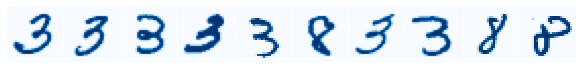

First 10 validation examples:


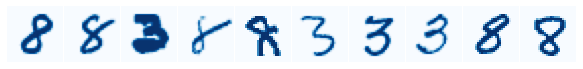

In [3]:
class0,class1 = 3,8   #1,5  #3,8
xnijT,ynT,xnijV,ynV = select (inputs, outputs, [class0,class1], [2500,2500], [2500,2500], shuffle=True) 

print ('First 10 training examples:');   gallery(xnijT[:10], cmap='Blues') ; plt.show()
print ('First 10 validation examples:'); gallery(xnijV[:10], cmap='Blues') ; plt.show()
#======== FLATTEN 28x28 IMAGES INTO 784-ELEMENT VECTORS, AND UNFLATTEN OUTPUTS INTO 1-ELEMENT VECTORS
xndT = xnijT.flatten (1,-1) ; yndT = (ynT.reshape (-1,1) - class0) / (class1-class0)
xndV = xnijV.flatten (1,-1) ; yndV = (ynV.reshape (-1,1) - class0) / (class1-class0)
_,imax,jmax = xnijT.shape
_,dmax = xndT.shape

---
## 3. Define a CNN and examine its effect on an image before training

Similar to LeNet-5.

In [4]:
#======== DEFINE MODEL
model = nn.Sequential(               # 28x28 ?
  nn.Unflatten (1, (1,28,28)),       # 1x28x28
  nn.Conv2d    (1, 1, 5, padding=2), # 1x28x28 (after conv with 5x5 kernel and 2x2 padding)
  nn.ReLU(),
  nn.MaxPool2d (2),                  # 1x14x14 after pooling layer with 2x2 kernel
  nn.Conv2d    (1, 1, 5),            # 1x10x10 after conv with 5x5 kernel and no padding
  nn.ReLU(),
  nn.MaxPool2d (2),                  # 1x5x5
  nn.Flatten(),    
  nn.Linear(5*5,84),                 # 84
  nn.ReLU(),
  nn.Linear(84,1),                   # 1
  nn.Sigmoid()
)

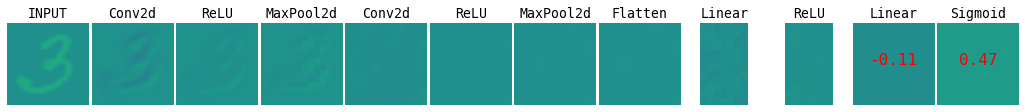

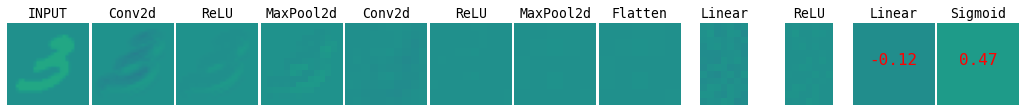

In [5]:
examine (xndT[ 0:]  [:1])
examine (xndT[3:] [:1])

The images above correspond to the output of each layer of the neural network, up to the Flatten() layer.
(After flattening, the data is no longer in the form of a matrix.)

---
## 4. Train the CNN to do binary classification

In [6]:
lossFunc  = nn.BCELoss()
optimizer = torch.optim.Adam (model.parameters(), lr=0.003)
#================ TRAIN
lossHistory = []
errorHistory = []
model.train()     # choose training mode
def fractionalError (Ynd, ynd):
  yn = ynd.detach().numpy().round().flatten().astype(int)
  Yn = Ynd.detach().numpy().round().flatten().astype(int)
  return np.mean(Yn != yn)
for epoch in range(30001):
  YndT = model(xndT)
  loss = lossFunc(YndT,yndT)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  loss = loss.item()
  lossHistory.append ([epoch,loss])
  if epoch % 5 == 0:
    err = fractionalError (YndT, yndT)
    YndV = model (xndV)
    errV = fractionalError (YndV, yndV)
    errorHistory.append ([epoch, err, errV])
    if epoch % 20 == 0:
      print ('Epoch {:5}  Training loss = {:.4f}  Training error = {:.2f}%  Validation error = {:.2f}%'.format(epoch,loss,100*err,100*errV))
  if (loss < 0.01): 
    print ('Termination criteria satisfied!')
    break

Epoch     0  Training loss = 0.6944  Training error = 50.00%  Validation error = 50.00%
Epoch    20  Training loss = 0.5738  Training error = 12.30%  Validation error = 13.40%
Epoch    40  Training loss = 0.1914  Training error = 6.52%  Validation error = 7.18%
Epoch    60  Training loss = 0.0869  Training error = 2.92%  Validation error = 3.18%
Epoch    80  Training loss = 0.0607  Training error = 1.98%  Validation error = 2.26%
Epoch   100  Training loss = 0.0483  Training error = 1.42%  Validation error = 1.88%
Epoch   120  Training loss = 0.0404  Training error = 1.20%  Validation error = 1.58%
Epoch   140  Training loss = 0.0357  Training error = 0.94%  Validation error = 1.34%
Epoch   160  Training loss = 0.0324  Training error = 0.90%  Validation error = 1.22%
Epoch   180  Training loss = 0.0297  Training error = 0.80%  Validation error = 1.20%
Epoch   200  Training loss = 0.0270  Training error = 0.70%  Validation error = 1.10%
Epoch   220  Training loss = 0.0242  Training erro

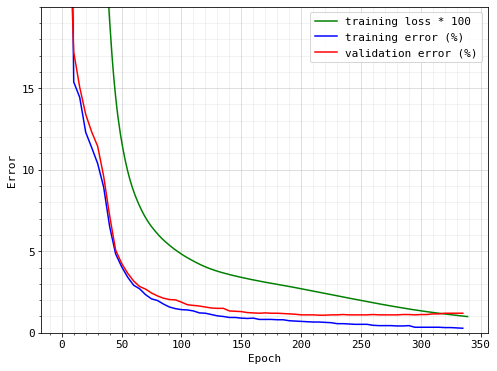

In [7]:
figure = plt.figure(figsize=(8,6))
lossHistory = np.array(lossHistory)
errorHistory = np.array(errorHistory)
plt.plot (lossHistory[:,0],  100*lossHistory[:,1], 'g', label='training loss * 100')
plt.plot (errorHistory[:,0], 100*errorHistory[:,1], 'b', label='training error (%)')
plt.plot (errorHistory[:,0], 100*errorHistory[:,2], 'r', label='validation error (%)')
plt.xlabel ("Epoch"); plt.ylabel ("Error"); plt.ylim ([0,20])
plt.minorticks_on(); plt.yticks(np.arange(0,20,5))
plt.grid (which='major', alpha=0.5)
plt.grid (which='minor', alpha=0.2)
plt.legend();

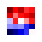

First Convolutional Layer Weights


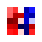

Second Convolutional Layer Weights
Training Examples:


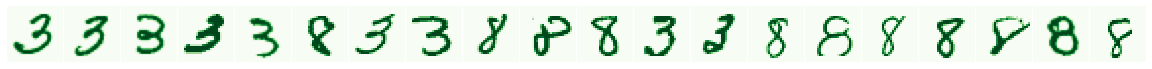

Validation Examples (any misclassified images are shown in red):


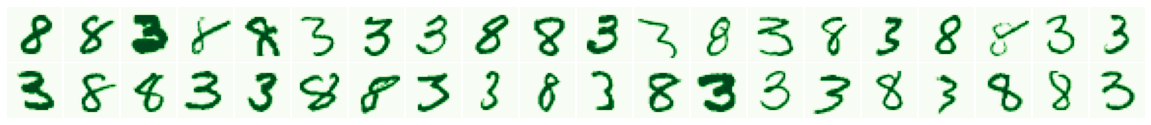

Training error   =   13/5000 =  0.3%    Confusion matrix = [[2490, 10], [3, 2497]]
Validation error =   60/5000 =  1.2%    Confusion matrix = [[2467, 33], [27, 2473]]


In [8]:
#================ EVALUATE ACCURACY FOR BOTH TRAINING AND VALIDATION SETS
model.eval()             # choose evaluation mode
YndT = model(xndT)
YndV = model(xndV)
YnT = YndT.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynT = yndT.detach().numpy().flatten().astype(int)          # this is already an integer
YnV = YndV.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynV = yndV.detach().numpy().flatten().astype(int)          # this is already an integer
#================ DISPLAY WEIGHTS
wccij = model[1].weight.detach() ; wcij = wccij.flatten(0,1).numpy()
cmax,I,J = wcij.shape
gallery (wcij, cmap='seismic', size=.5)
plt.show() ; print ('First Convolutional Layer Weights')
wccij = model[4].weight.detach() ; wcij = wccij.flatten(0,1).numpy()
cmax,I,J = wcij.shape
gallery (wcij, cmap='seismic', size=.5) #labels=['Channel {}'.format(c) for c in range(cmax)], 
plt.show() ; print ('Second Convolutional Layer Weights')
#================ DISPLAY SOME IMAGES AND CLASSIFICATIONS
plt.show() ; print ('Training Examples:')
gallery (xnijT[:20], size=1, cmap=np.where(YnT==ynT,'Greens','Reds'));  #labels=['T{}'.format(n) for n in range(nmax)],
plt.show() ; print ('Validation Examples (any misclassified images are shown in red):')
gallery (xnijV[:40], size=1, cmap=np.where(YnV==ynV,'Greens','Reds')); plt.show();
#================ PRINT METRICS
ntot,nerr,Cnn = metrics (YnT, ynT)
print("Training error   = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))
ntot,nerr,Cnn = metrics (YnV, ynV)
print("Validation error = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))

---
## 5. Examine contents of hidden layers

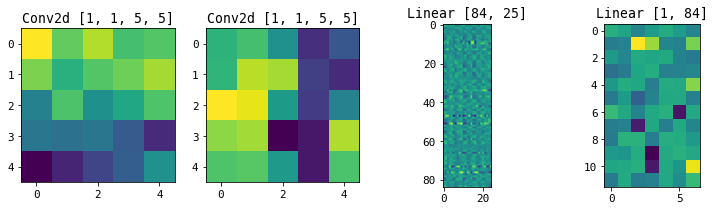

In [12]:
#================ DISPLAY WEIGHTS
iPanel = 0
layers = []
for layer in model:
  if hasattr (layer, 'weight'):
    layers += [layer]
    
plt.figure(figsize=(len(layers)*4,3))
for layer in layers:
  title = str(layer).split('(') [0]
  wd = layer.weight.detach()
  if len(wd.shape) >= 4:  wd = wd[0,0]
  wd = wd.squeeze()
  if len(wd.shape) == 1:  wd = wd.reshape (factorInt(len(wd)))
  wij = wd
  plt.subplot(1,1+len(layers),1+iPanel)
  plt.imshow (wij)
  plt.title (title + ' ' + str(list(layer.weight.shape)))
  iPanel += 1

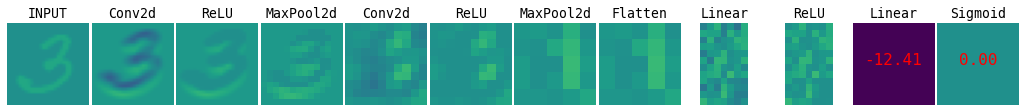

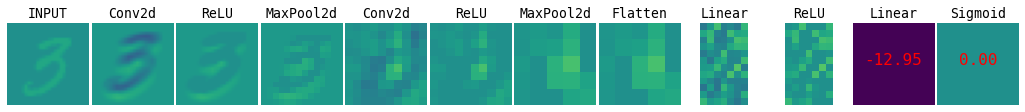

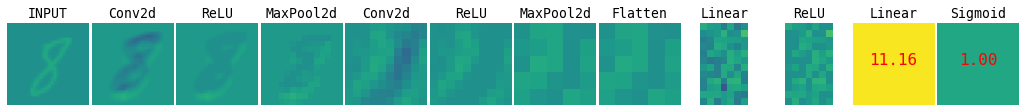

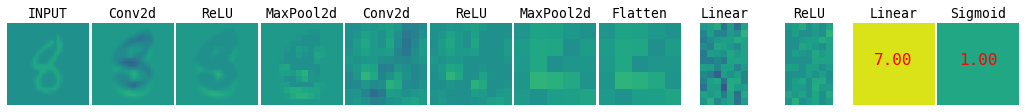

In [15]:
#================ DISPLAY WEIGHTS
examine ( xndT[0: ][0:1] )
examine ( xndT[1: ][0:1] )
examine ( xndT[25: ][0:1] )
examine ( xndT[30: ][0:1] )

The output of the linear layer tells us the decision.

---

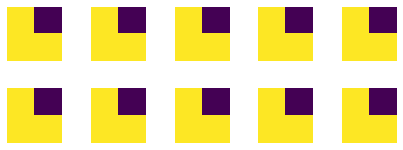

In [11]:
wspace = hspace = .5;
fig,axs = plt.subplots (2,5, figsize=(5+(5-1)*wspace,2+(2-1)*hspace), gridspec_kw={'wspace':wspace,'hspace':hspace})
for ax in axs.flatten():
  ax.imshow ([[1,0],[1,1]]) ; ax.axis('off') ; ax.set_aspect('equal')